# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [4]:
X_train_feats.shape

(49000, 155)

In [5]:
y_train.shape

(49000,)

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [12]:
# Use the validation set to tune the learning rate and regularization strength
from sklearn.metrics import accuracy_score

from cs231n.classifiers.linear_classifier import LinearSVM

# Coarse search
#learning_rates = [1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6, 1e-5]
#regularization_strengths = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6]
# lr 3e-08 reg 3e+05 train accuracy: 0.416429 val accuracy: 0.429000

# Fine search
learning_rates = [9e-9, 1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 6e-8]
regularization_strengths = [9e4, 1e5, 2e5, 3e5, 4e5, 5e5, 6e5]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg_str in regularization_strengths:
        svm = LinearSVM()
        _ = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg_str, num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        results[(lr, reg_str)] = (accuracy_score(y_train, y_train_pred), 
                                  accuracy_score(y_val, y_val_pred))
        if accuracy_score(y_val, y_val_pred) > best_val:
            best_val = accuracy_score(y_val, y_val_pred)
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 9.000000e-09 reg 9.000000e+04 train accuracy: 0.103776 val accuracy: 0.086000
lr 9.000000e-09 reg 1.000000e+05 train accuracy: 0.102224 val accuracy: 0.103000
lr 9.000000e-09 reg 2.000000e+05 train accuracy: 0.163347 val accuracy: 0.151000
lr 9.000000e-09 reg 3.000000e+05 train accuracy: 0.375918 val accuracy: 0.373000
lr 9.000000e-09 reg 4.000000e+05 train accuracy: 0.412837 val accuracy: 0.418000
lr 9.000000e-09 reg 5.000000e+05 train accuracy: 0.415776 val accuracy: 0.420000
lr 9.000000e-09 reg 6.000000e+05 train accuracy: 0.413327 val accuracy: 0.414000
lr 1.000000e-08 reg 9.000000e+04 train accuracy: 0.109347 val accuracy: 0.124000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.094551 val accuracy: 0.097000
lr 1.000000e-08 reg 2.000000e+05 train accuracy: 0.205735 val accuracy: 0.210000
lr 1.000000e-08 reg 3.000000e+05 train accuracy: 0.404204 val accuracy: 0.403000
lr 1.000000e-08 reg 4.000000e+05 train accuracy: 0.416204 val accuracy: 0.413000
lr 1.000000e-08 reg 5.000000

In [13]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.425


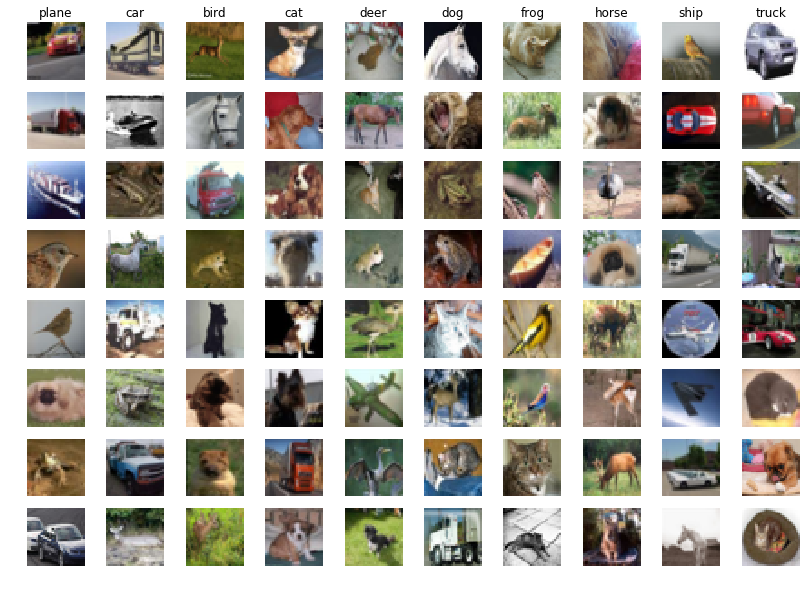

In [15]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
%matplotlib inline

plt.figure(figsize=(14,10))

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [6]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [65]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
regs = [5e-5, 6e-5, 7e-5, 8e-5, 9e-5]
val_accs = []
nets = []
stats_list = []

for reg_str in regs:    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=10000, batch_size=200,
                learning_rate=1, learning_rate_decay=0.98,
                reg=reg_str, verbose=False)
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    val_accs.append(val_acc)
    nets.append(net)
    stats_list.append(stats)

# Predict on the validation set
#val_acc = (net.predict(X_val_feats) == y_val).mean()
#print('Validation accuracy: ', val_acc)

best_net = nets[np.argmax(val_accs)]
print('Best validation accuracy: ', val_accs[np.argmax(val_accs)])
print('Best lambda: ', regs[np.argmax(val_accs)])
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Best validation accuracy:  0.573
Best lambda:  7e-05


<br>
<br>

In [11]:
from cs231n.classifiers.neural_net import TwoLayerNet
from scipy.stats import uniform
from sklearn.metrics import accuracy_score

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)

In [53]:
# Random hyperparameter search
input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)

val_accs = []
params = []

# Coarse search

for count in range(100):
    lr = 10**uniform(-4,4).rvs()
    reg_str = 10**uniform(-7,4).rvs()
    lr_decay = uniform(0.95,0.045).rvs()
    
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    _ = net.train(X_train_feats, y_train, X_val_feats, y_val,
                      num_iters=1000, batch_size=200,
                      learning_rate=lr, learning_rate_decay=lr_decay,
                      reg=reg_str, verbose=False)
    val_acc = accuracy_score(y_val, net.predict(X_val_feats))
    
    val_accs.append(val_acc)
    params.append((lr, reg_str, lr_decay))
    print("val acc: {:.4f}, lr: {:.2e}, lr decay: {:.4f}, reg: {:.2e}, ({}/100)".format(val_acc, 
                                                                                        lr, 
                                                                                        lr_decay, 
                                                                                        reg_str,
                                                                                        count+1))

val acc: 0.0980, lr: 2.44e-03, lr decay: 0.9847, reg: 2.45e-05, (1/100)
val acc: 0.5730, lr: 5.37e-01, lr decay: 0.9792, reg: 7.52e-06, (2/100)
val acc: 0.5530, lr: 3.24e-01, lr decay: 0.9927, reg: 2.90e-05, (3/100)
val acc: 0.2230, lr: 1.64e-02, lr decay: 0.9824, reg: 1.59e-07, (4/100)
val acc: 0.5920, lr: 5.70e-01, lr decay: 0.9632, reg: 1.13e-06, (5/100)
val acc: 0.1050, lr: 6.84e-04, lr decay: 0.9830, reg: 3.00e-06, (6/100)
val acc: 0.3440, lr: 3.24e-02, lr decay: 0.9620, reg: 2.87e-06, (7/100)
val acc: 0.1070, lr: 1.45e-02, lr decay: 0.9778, reg: 2.08e-06, (8/100)
val acc: 0.1120, lr: 8.47e-04, lr decay: 0.9571, reg: 3.37e-07, (9/100)
val acc: 0.5510, lr: 1.83e-01, lr decay: 0.9864, reg: 1.91e-05, (10/100)
val acc: 0.3900, lr: 3.84e-02, lr decay: 0.9894, reg: 7.64e-04, (11/100)
val acc: 0.0870, lr: 2.94e-04, lr decay: 0.9768, reg: 8.08e-04, (12/100)
val acc: 0.5840, lr: 5.44e-01, lr decay: 0.9692, reg: 8.65e-07, (13/100)
val acc: 0.0870, lr: 6.92e-04, lr decay: 0.9570, reg: 4.49e-

In [80]:
idx = np.argsort(val_accs)[-10:]

print("Best params:\n")
for i in idx:
    print("val acc: {:.4f}, lr: {:.2e}, lr decay: {:.4f}, reg: {:.2e}".format(val_accs[i], 
                                                                              params[i][0], 
                                                                              params[i][2], 
                                                                              params[i][1]))

Best params:

val acc: 0.5750, lr: 8.53e-01, lr decay: 0.9647, reg: 3.57e-05
val acc: 0.5780, lr: 4.59e-01, lr decay: 0.9940, reg: 3.65e-07
val acc: 0.5810, lr: 7.44e-01, lr decay: 0.9552, reg: 3.20e-07
val acc: 0.5820, lr: 4.36e-01, lr decay: 0.9668, reg: 1.36e-07
val acc: 0.5830, lr: 7.04e-01, lr decay: 0.9568, reg: 2.74e-07
val acc: 0.5840, lr: 5.80e-01, lr decay: 0.9852, reg: 1.31e-07
val acc: 0.5840, lr: 5.44e-01, lr decay: 0.9692, reg: 8.65e-07
val acc: 0.5880, lr: 4.51e-01, lr decay: 0.9725, reg: 6.73e-07
val acc: 0.5920, lr: 5.70e-01, lr decay: 0.9632, reg: 1.13e-06
val acc: 0.6010, lr: 7.47e-01, lr decay: 0.9501, reg: 6.39e-05


In [12]:
# Finer search

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

val_accs = []
params = []

for count in range(100):
    lr = 10**uniform(-1,1).rvs()
    lr_decay = uniform(0.965,0.020).rvs()
    reg_str = 10**uniform(-5,1).rvs()

    
    
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                      num_iters=3000, batch_size=200,
                      learning_rate=lr, learning_rate_decay=lr_decay,
                      reg=reg_str, verbose=False)
    val_acc = accuracy_score(y_val, net.predict(X_val_feats))
    
    val_accs.append(val_acc)
    params.append((lr, reg_str, lr_decay))
    
    
    print("val acc: {:.4f}, lr: {:.2e}, lr decay: {:.4f}, reg: {:.2e}, ({}/100)".format(val_acc, 
                                                                                        lr, 
                                                                                        lr_decay, 
                                                                                        reg_str,
                                                                                        count+1))

val acc: 0.5630, lr: 7.80e-01, lr decay: 0.9720, reg: 2.41e-05, (1/100)
val acc: 0.5770, lr: 1.12e-01, lr decay: 0.9774, reg: 7.60e-05, (2/100)
val acc: 0.5850, lr: 1.59e-01, lr decay: 0.9849, reg: 4.44e-05, (3/100)
val acc: 0.5850, lr: 3.48e-01, lr decay: 0.9716, reg: 8.53e-05, (4/100)
val acc: 0.5900, lr: 1.21e-01, lr decay: 0.9766, reg: 8.53e-05, (5/100)
val acc: 0.5920, lr: 3.58e-01, lr decay: 0.9671, reg: 3.02e-05, (6/100)
val acc: 0.5800, lr: 2.58e-01, lr decay: 0.9817, reg: 1.62e-05, (7/100)
val acc: 0.5780, lr: 2.75e-01, lr decay: 0.9723, reg: 4.06e-05, (8/100)
val acc: 0.5780, lr: 2.98e-01, lr decay: 0.9739, reg: 4.39e-05, (9/100)
val acc: 0.5850, lr: 4.36e-01, lr decay: 0.9722, reg: 7.14e-05, (10/100)
val acc: 0.6000, lr: 1.49e-01, lr decay: 0.9750, reg: 2.86e-05, (11/100)
val acc: 0.5820, lr: 1.30e-01, lr decay: 0.9738, reg: 3.43e-05, (12/100)
val acc: 0.5750, lr: 1.23e-01, lr decay: 0.9741, reg: 8.49e-05, (13/100)
val acc: 0.5910, lr: 2.63e-01, lr decay: 0.9769, reg: 1.18e-

In [13]:
idx = np.argsort(val_accs)[-10:]

print("Best params:\n")
for i in idx:
    print("val acc: {:.4f}, lr: {:.2e}, lr decay: {:.4f}, reg: {:.2e}".format(val_accs[i], 
                                                                              params[i][0], 
                                                                              params[i][2], 
                                                                              params[i][1]))

Best params:

val acc: 0.5980, lr: 1.41e-01, lr decay: 0.9818, reg: 1.81e-05
val acc: 0.5990, lr: 2.11e-01, lr decay: 0.9752, reg: 4.70e-05
val acc: 0.5990, lr: 4.05e-01, lr decay: 0.9677, reg: 1.05e-05
val acc: 0.6000, lr: 1.49e-01, lr decay: 0.9750, reg: 2.86e-05
val acc: 0.6000, lr: 6.03e-01, lr decay: 0.9712, reg: 7.36e-05
val acc: 0.6020, lr: 1.95e-01, lr decay: 0.9662, reg: 5.84e-05
val acc: 0.6060, lr: 2.30e-01, lr decay: 0.9838, reg: 1.72e-05
val acc: 0.6060, lr: 3.12e-01, lr decay: 0.9705, reg: 1.77e-05
val acc: 0.6070, lr: 3.55e-01, lr decay: 0.9798, reg: 9.12e-05
val acc: 0.6120, lr: 1.62e-01, lr decay: 0.9822, reg: 8.24e-05


<br>
<br>

In [50]:
# Best
# val acc: 0.6160, lr: 3.86e-01, lr decay: 0.9725, reg: 1.81e-05

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                  num_iters=3000, batch_size=200,
                  learning_rate=1.62e-01, learning_rate_decay=0.9822,
                  reg=8.24e-05, verbose=False)
val_acc = accuracy_score(y_val, net.predict(X_val_feats))
    
print(val_acc)
best_net = net

0.593


Because batches are created by sampling with replacement from the training set (without cycling through the entire training set for each epoch), specific hyperparameter selections don't result in deterministic performance.

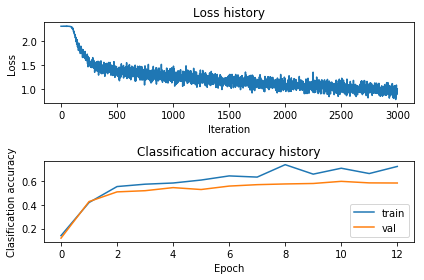

In [51]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.tight_layout()

In [52]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.587
